Importing plotly failed. Interactive plots will not work.


Text(0.5, 1.0, 'Test')

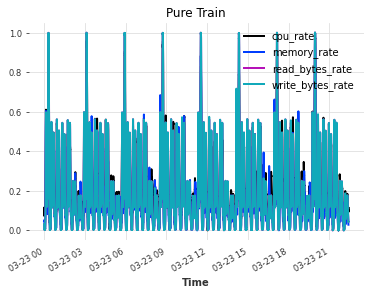

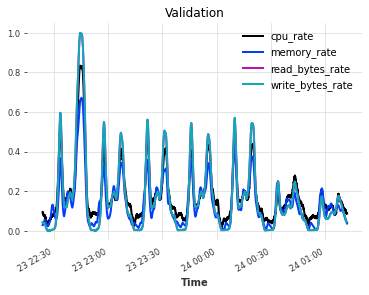

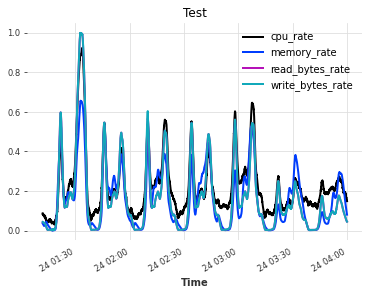

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/cit/lib/"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)

import sys
sys.path.append("/home/jupyter-babakesistani/adaptive-monitoring-nn/")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt
# import tsaug
# import ray
# from ray import tune

from matplotlib.pyplot import figure

dl =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/cpu_memory_disk_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-03-23 00:00:00")
scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_train = 8*scaled_one_week
idx_val = 9*scaled_one_week
train = dl.series_scaled[:idx_train]
val = dl.series_scaled[idx_train:idx_val]
test = dl.series_scaled[idx_val:-1]
    
train.plot()
plt.title("Pure Train")

val.plot(new_plot=True)
plt.title("Validation")

test.plot(new_plot=True)
plt.title("Test")

In [2]:
def day_of_week(idxs):
    days = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) // (24*60)) % 7
    encoders = []
    for day in days:
        if day == 0:
            encoders.append(1)
        elif day == 1 or day == 2 or day == 3 or day == 4: 
            encoders.append(2)
        elif day == 5 or day == 6:
            encoders.append(3)
    return encoders

def minute_of_day(idxs):    
    minute_of_day = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) % (24*60))
    return minute_of_day


Text(0.5, 1.0, 'Validation')

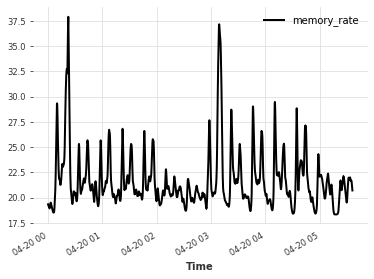

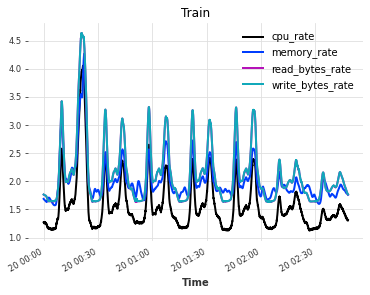

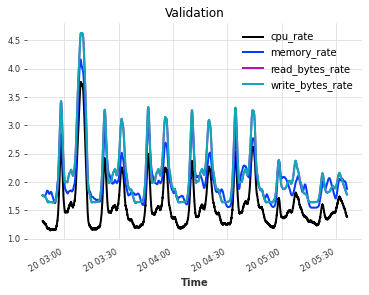

In [12]:
from darts import TimeSeries

dl_retrain =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/23_may_shifted.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-04-20 00:00:00")
retrain_df = dl_retrain.darts_df
retrain_df["cpu_rate"] = 2 * retrain_df["cpu_rate"]
retrain_df["memory_rate"] = 2 * retrain_df["memory_rate"]
retrain_df["read_bytes_rate"] = 2 * retrain_df["read_bytes_rate"]
retrain_df["write_bytes_rate"] = 2 * retrain_df["write_bytes_rate"]

retrain_series = TimeSeries.from_dataframe(retrain_df, dl_retrain.time_col, dl_retrain.target_cols)
retrain_series['memory_rate'].plot()

retrain_series = dl.scaler.transform(retrain_series)

scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_train = 1*scaled_one_week
idx_val = 2*scaled_one_week

train_retrain = retrain_series[:idx_train]
val_retrain = retrain_series[idx_train:idx_val]

# test = retrain_series
# val = retrain_series[idx_train:idx_val]

    
train_retrain.plot(new_plot=True)
plt.title("Train")

val_retrain.plot(new_plot=True)
plt.title("Validation")

In [4]:
# from darts import TimeSeries

# dl_retrain =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/23_may_shifted.csv', "Time",
#                                                                     [
#                                                                       "cpu_rate",
#                                                                       "memory_rate",
#                                                                       "read_bytes_rate",
#                                                                       "write_bytes_rate"
#                                                                      ],
#                     augment=False, resample_freq="1s", shift_df_datetime="2022-04-20 00:00:00")
# retrain_df = dl_retrain.darts_df
# retrain_series = TimeSeries.from_dataframe(retrain_df, dl_retrain.time_col, dl_retrain.target_cols)
# retrain_series = dl.scaler.transform(retrain_series)

# scaled_one_day = 24*60
# scaled_one_week = 7*24*60
# idx_train = 1*scaled_one_week
# idx_val = 2*scaled_one_week

# train_retrain = retrain_series[:idx_train]
# val_retrain = retrain_series[idx_train:idx_val]

# # test = retrain_series
# # val = retrain_series[idx_train:idx_val]

    
# train_retrain.plot()
# plt.title("Train")

# val_retrain.plot(new_plot=True)
# plt.title("Validation")

# # test.plot(new_plot=True)
# # plt.title("Test")

In [4]:
model = BlockRNNModel.load_model("retrained.pth.tar")

In [5]:
from typing import Union, Optional
DIMS = ("time", "component", "sample")
def plot_custom(
        self,
        new_plot: bool = False,
        central_quantile: Union[float, str] = 0.5,
        low_quantile: Optional[float] = 0.1,
        high_quantile: Optional[float] = 0.9,
        label_to_use = None,
        *args,
        **kwargs):
        alpha_confidence_intvls = 0.25

        fig = (
            plt.figure()
            if new_plot
            else (kwargs["figure"] if "figure" in kwargs else plt.gcf())
        )
        kwargs["figure"] = fig
        label = kwargs["label"] if "label" in kwargs else ""

        if not any(lw in kwargs for lw in ["lw", "linewidth"]):
            kwargs["lw"] = 2

        if self.n_components > 10:
            logger.warn(
                "Number of components is larger than 10 ({}). Plotting only the first 10 components.".format(
                    self.n_components
                )
            )

        for i, c in enumerate(self._xa.component[:10]):
            comp_name = str(c.values)

            if i > 0:
                kwargs["figure"] = plt.gcf()

            comp = self._xa.sel(component=c)

            if comp.sample.size > 1:
                if central_quantile == "mean":
                    central_series = comp.mean(dim=DIMS[2])
                else:
                    central_series = comp.quantile(q=central_quantile, dim=DIMS[2])
            else:
                central_series = comp.mean(dim=DIMS[2])

            # temporarily set alpha to 1 to plot the central value (this way alpha impacts only the confidence intvls)
            alpha = kwargs["alpha"] if "alpha" in kwargs else None
            kwargs["alpha"] = 1

#             label_to_use = (
#                 (label + ("_" + str(i) if len(self.components) > 1 else ""))
#                 if label != ""
#                 else "" + str(comp_name)
#             )
            if label_to_use:
                kwargs["label"] = label_to_use

            p = central_series.plot(*args, **kwargs)
            color_used = p[0].get_color()
            kwargs["alpha"] = alpha if alpha is not None else alpha_confidence_intvls

            # Optionally show confidence intervals
            if (
                comp.sample.size > 1
                and low_quantile is not None
                and high_quantile is not None
            ):
                low_series = comp.quantile(q=low_quantile, dim=DIMS[2])
                high_series = comp.quantile(q=high_quantile, dim=DIMS[2])
                plt.fill_between(
                    self.time_index,
                    low_series,
                    high_series,
                    color=color_used,
                    alpha=(
                        alpha_confidence_intvls
                        if "alpha" not in kwargs
                        else kwargs["alpha"]
                    ),
                )

        plt.legend()
        plt.title(self._xa.name)


In [6]:
def merge_prediction_fetched_series(prediction, fetched_series) :
        if len(fetched_series.columns) == len(prediction.columns):
            return fetched_series

        if prediction.start_time() != fetched_series.start_time():
            print("prediction and fetched series start time are different: " \
                            + str(prediction.start_time()) + "<>" + str(fetched_series.start_time()))
            raise NotImplementedError
        
        if prediction.end_time() < fetched_series.end_time():
            print("prediction and fetched series end time are different: " \
                            + str(prediction.end_time()) + "<>" + str(fetched_series.end_time()))
            raise NotImplementedError
        prediction_components = prediction.components.to_list()
        fetched_series_components = fetched_series.components.to_list()
        result = None
        
        for component in prediction_components:
            if not result:
                if component in fetched_series_components:
                    result = fetched_series[component]
                    continue
                result = prediction[component]
                continue
            if component in fetched_series_components:
                result = result.concatenate(fetched_series[component], axis=1)
                continue
            result = result.concatenate(prediction[component], axis=1)
        return result

def get_cols_to_fetch(prediction, std_threshold):
    cols_to_fetch = []
    for i, component in enumerate(prediction.components):  
        pred = prediction.univariate_component(i)
        pred = pred.all_values()  # Time X Components X samples
        pred = np.squeeze(pred)  # Time X samples
        std = np.mean(np.std(pred, axis=1))
        if std > std_threshold:
            cols_to_fetch.append(component)
    return cols_to_fetch

In [7]:
# std_ths = np.linspace(0.005, 0.05, num=int((0.05-0.005)//0.0025+1))
# std_ths = [0.01, 0.0225, 0.0475]
std_ths = [0.01, 0.0175, 0.0225, 0.0475]

In [8]:
# std_ths = np.linspace(0.005, 0.05, num=int((0.05-0.005)//0.0025+1))
eval_test = val_retrain

saved_pct = {}
plot_dic = {}
for std_th in std_ths: 
    saved_pct[std_th] = {}
    plot_dic[std_th] = {}
    test_cols = eval_test.columns.to_list()
    for test_col in test_cols:
        saved_pct[std_th][test_col] = []
    print("std_th:", str(std_th))

    col_map = {}
    col_pct = {}

    for test_col in test_cols:
        col_map[test_col] = 0
    fetch_len = 300
    pred_len = 300
    last_fetch_len = 0
    len_test = len(eval_test)
    len_cols = len(eval_test.columns)
    series_to_predict = eval_test[last_fetch_len:last_fetch_len+fetch_len]
    last_fetch_len = last_fetch_len+fetch_len
    test_cols = eval_test.columns.to_list()

    #already fetched one series 
    pred_fetch_series = series_to_predict.pd_dataframe()

   
    for test_col in test_cols:
        plot_dic[std_th][test_col] = [series_to_predict[test_col]]


    for test_col in test_cols:
        col_map[test_col] += fetch_len


    stop = False
    while(not stop):
        if last_fetch_len+pred_len >= len_test:
            stop = True
            pred_len = len_test - last_fetch_len
        pred = model.predict(series=series_to_predict, n=pred_len, num_samples=500)
        cols_to_fetch = get_cols_to_fetch (pred,std_th)
        single_prediction =  model.predict(series=series_to_predict, n=pred_len)
        if not cols_to_fetch:
            series_to_predict = single_prediction
            pred_fetch_series = pd.concat([pred_fetch_series,series_to_predict.pd_dataframe()])
            for test_col in test_cols:
                plot_dic[std_th][test_col].append(pred[test_col])
            last_fetch_len = last_fetch_len + pred_len
            continue

        for col_tmp in cols_to_fetch:
            col_map[col_tmp]+=pred_len

        fetched_series = eval_test[cols_to_fetch][last_fetch_len:last_fetch_len + pred_len]


        for test_col in test_cols:
            if test_col in cols_to_fetch:
                plot_dic[std_th][test_col].append(fetched_series[test_col])
            else:
                plot_dic[std_th][test_col].append(pred[test_col])


        series_to_predict = merge_prediction_fetched_series(single_prediction, fetched_series)

        pred_fetch_series = pd.concat([pred_fetch_series,series_to_predict.pd_dataframe()])

        last_fetch_len = last_fetch_len + pred_len

    for col in col_map:
        saved_pct[std_th][col].append((col_map[col])/ len(eval_test) * 100.0)

std_th: 0.01
std_th: 0.0175
std_th: 0.0225
std_th: 0.0475


0.01


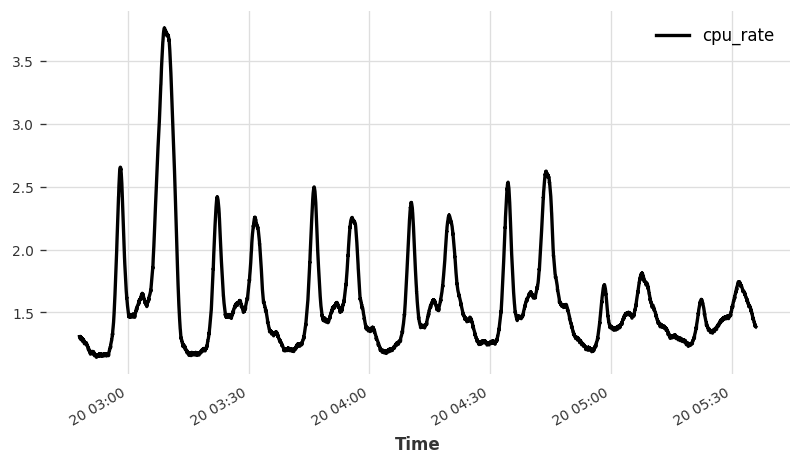

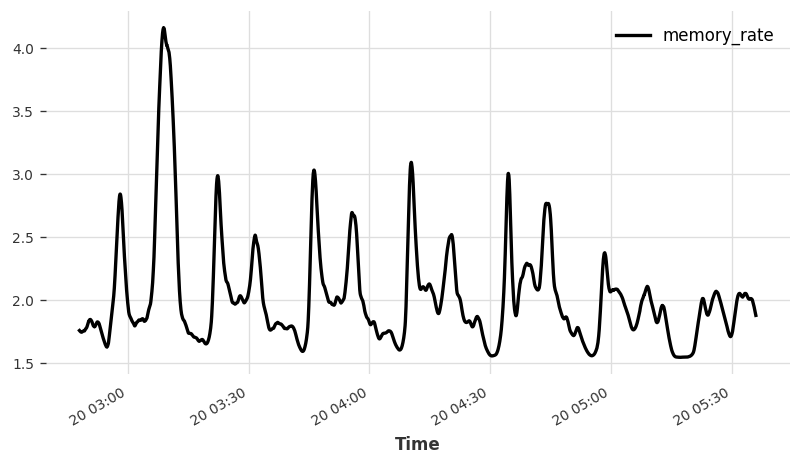

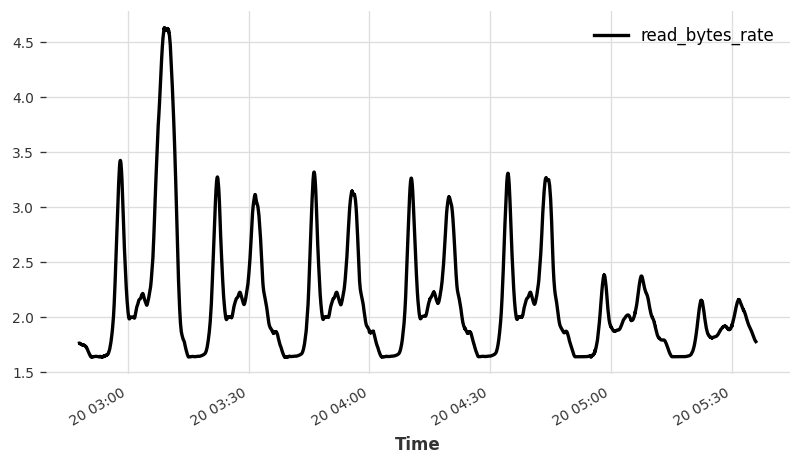

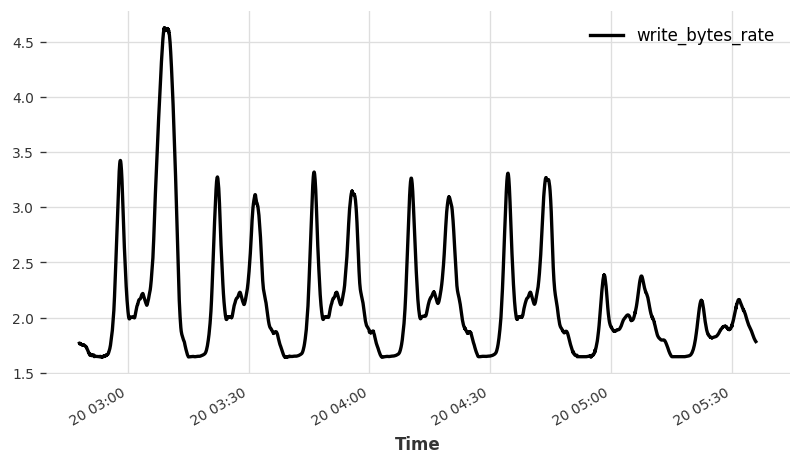

0.0175


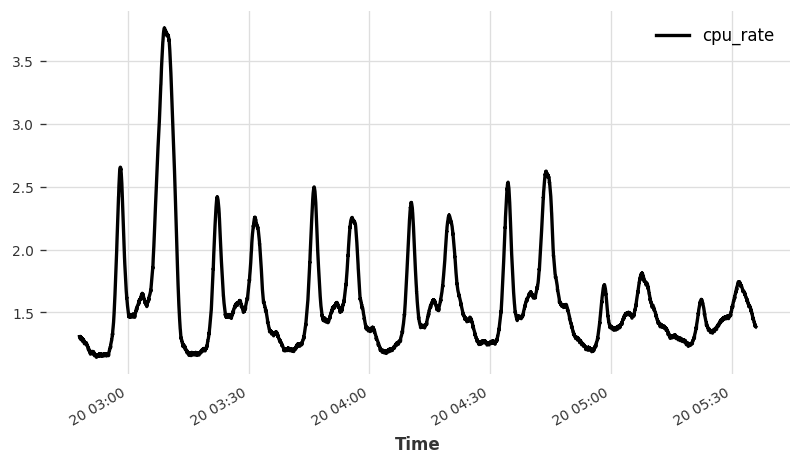

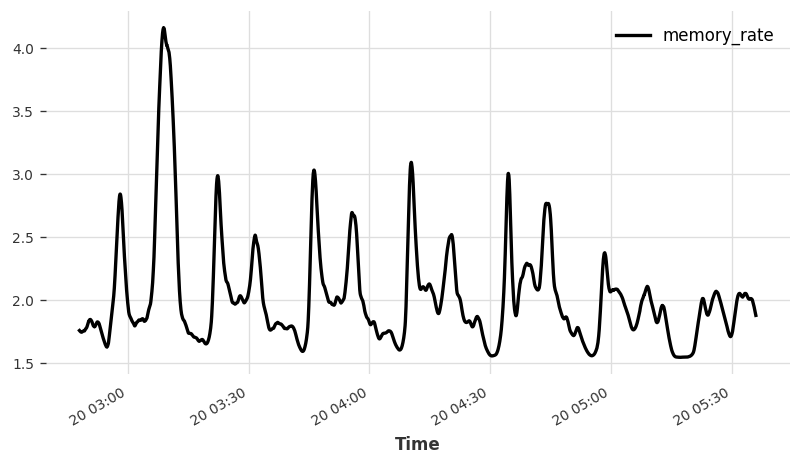

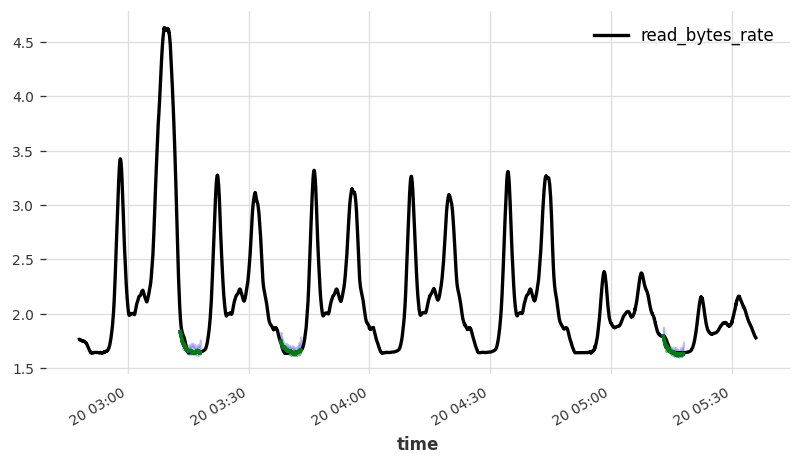

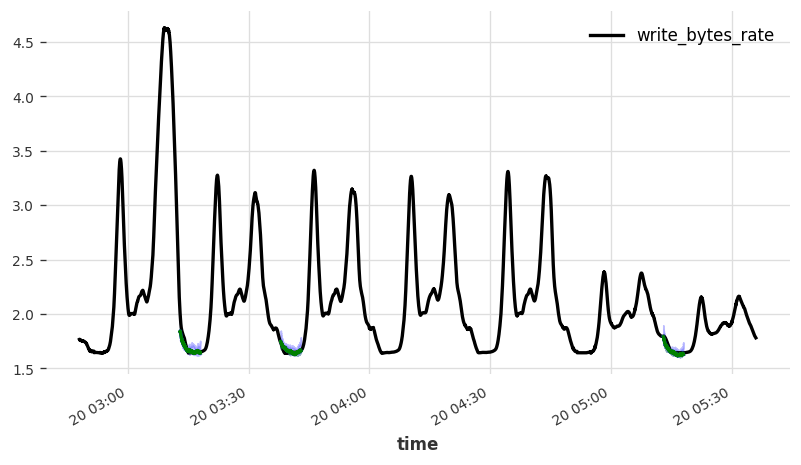

0.0225


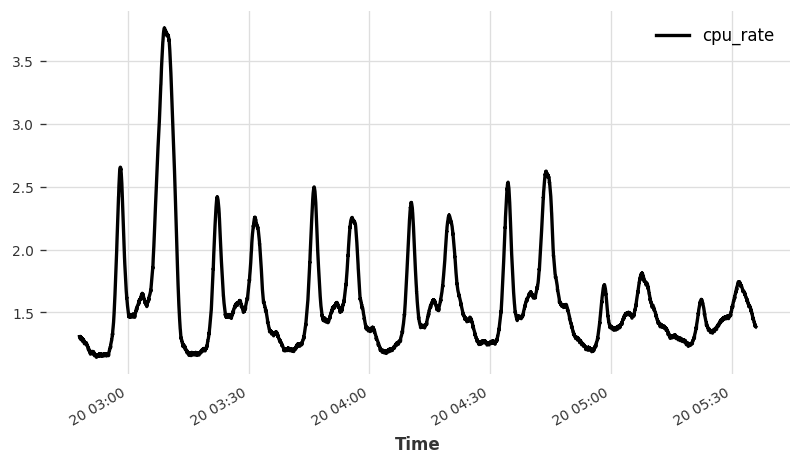

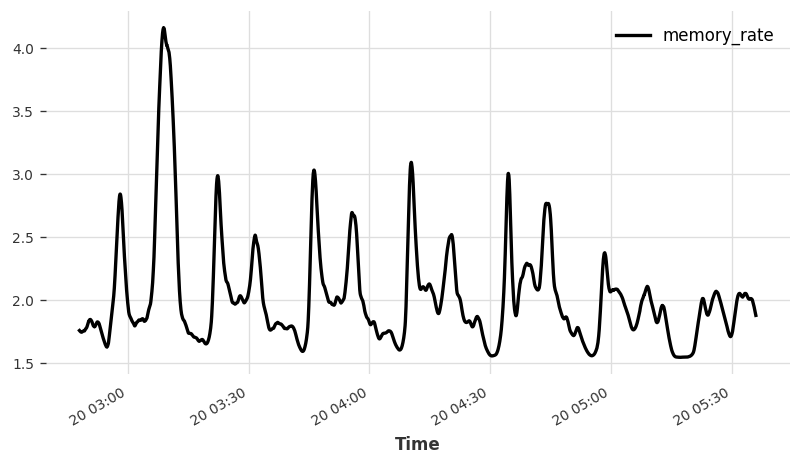

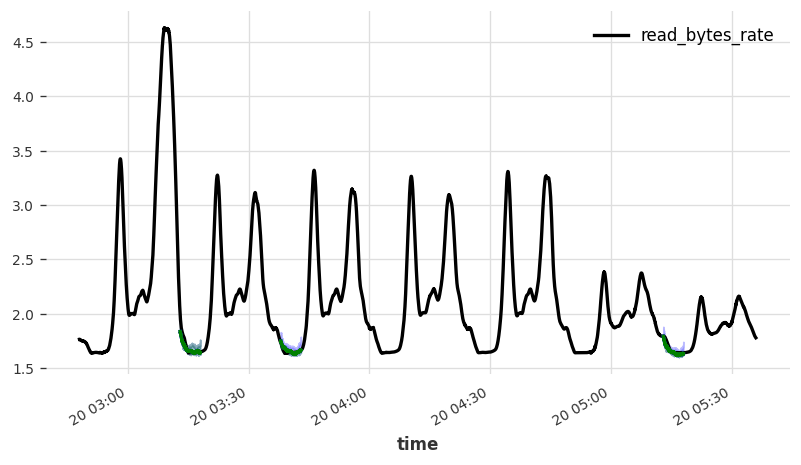

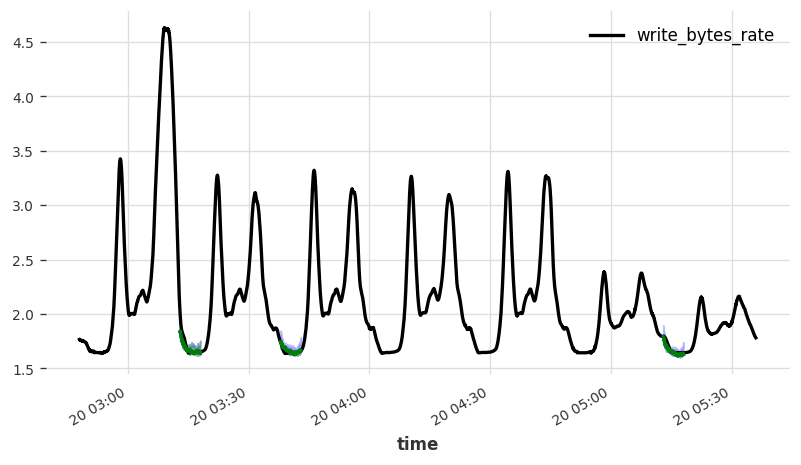

0.0475


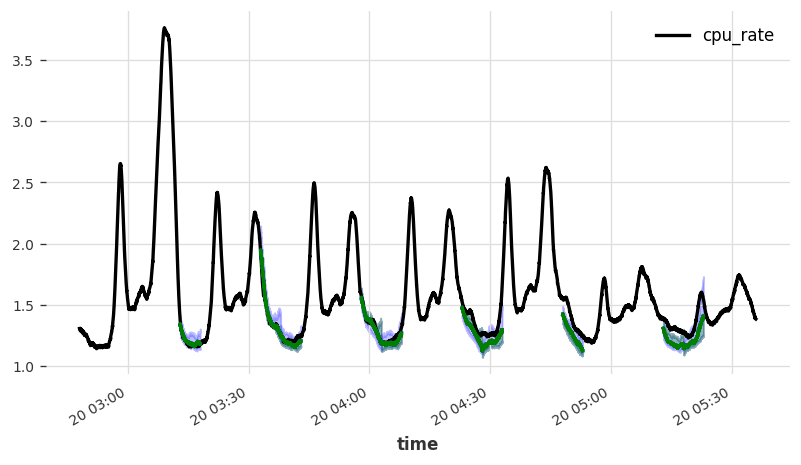

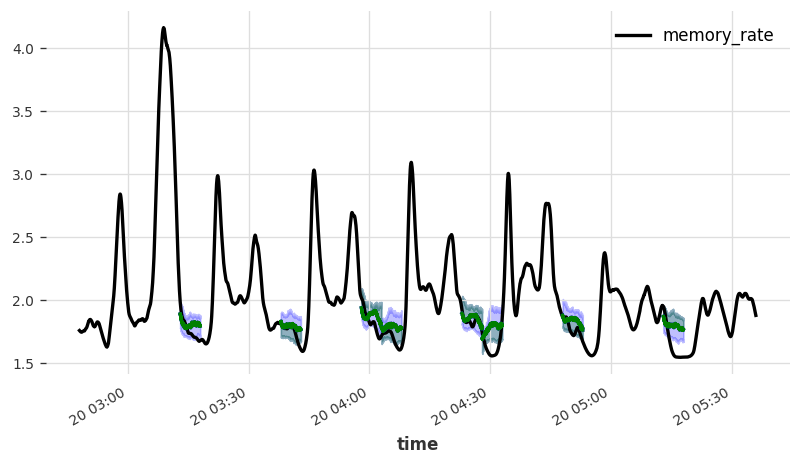

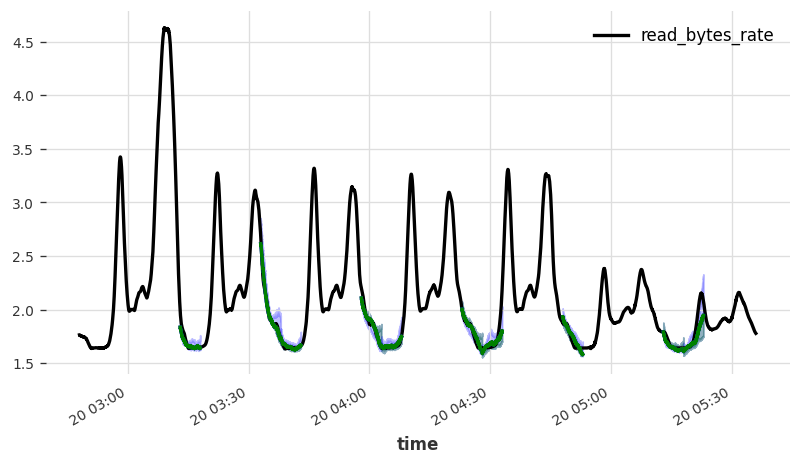

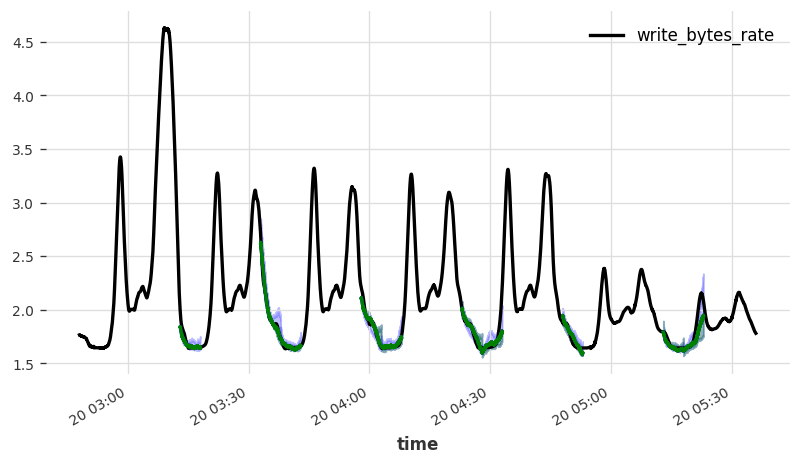

In [9]:
from matplotlib.pyplot import figure


# std_ths_plot = [ 0.05] 
for std_th in std_ths:
    print(std_th)
    for col_name in test_cols:

        figure(figsize=(8, 4), dpi=120)
        
        plots = []
        eval_test[col_name].plot()
        for series in plot_dic[std_th][col_name]:
            color="green"
    #         
            label_to_use="ground_truth"
            if series.is_probabilistic:
                color="blue"
                plot_custom (series,low_quantile=0.01, high_quantile=0.99, color=color)
                plot_custom (series,low_quantile=0.1, high_quantile=0.9, color="green")
        
        plt.show()

In [ ]:
from typing import Union, Optional
DIMS = ("time", "component", "sample")
def subplot_custom(
        self,
        ax, 
        fig,
        new_plot: bool = False,
        central_quantile: Union[float, str] = 0.5,
        low_quantile: Optional[float] = 0.1,
        high_quantile: Optional[float] = 0.9,
        label_to_use = None,
        *args,
        **kwargs):
        alpha_confidence_intvls = 0.25

#         fig = (
#             plt.figure()
#             if new_plot
#             else (kwargs["figure"] if "figure" in kwargs else plt.gcf())
#         )
#         kwargs["figure"] = fig
        label = kwargs["label"] if "label" in kwargs else ""

        if not any(lw in kwargs for lw in ["lw", "linewidth"]):
            kwargs["lw"] = 2

        if self.n_components > 10:
            logger.warn(
                "Number of components is larger than 10 ({}). Plotting only the first 10 components.".format(
                    self.n_components
                )
            )

        for i, c in enumerate(self._xa.component[:10]):
            comp_name = str(c.values)

            if i > 0:
                kwargs["figure"] = ax

            comp = self._xa.sel(component=c)

            if comp.sample.size > 1:
                if central_quantile == "mean":
                    central_series = comp.mean(dim=DIMS[2])
                else:
                    central_series = comp.quantile(q=central_quantile, dim=DIMS[2])
            else:
                central_series = comp.mean(dim=DIMS[2])

            # temporarily set alpha to 1 to plot the central value (this way alpha impacts only the confidence intvls)
            alpha = kwargs["alpha"] if "alpha" in kwargs else None
            kwargs["alpha"] = 1

#             label_to_use = (
#                 (label + ("_" + str(i) if len(self.components) > 1 else ""))
#                 if label != ""
#                 else "" + str(comp_name)
#             )
            if label:
#                 kwargs["label"] = label_to_use
                ax.plot(self.time_index,central_series,color=kwargs["color"],alpha=1, label= label)
            else:
                ax.plot(self.time_index,central_series,color=kwargs["color"],alpha=1)
                
#                 ax.plot(train["cpu_rate"])
              
#             p = central_series.plot(*args, **kwargs)
#             color_used = p[0].get_color()
            kwargs["alpha"] = alpha if alpha is not None else alpha_confidence_intvls

            # Optionally show confidence intervals
            if (
                comp.sample.size > 1
                and low_quantile is not None
                and high_quantile is not None
            ):
                low_series = comp.quantile(q=low_quantile, dim=DIMS[2])
                high_series = comp.quantile(q=high_quantile, dim=DIMS[2])
                if label_to_use:
                    ax.fill_between(
                        self.time_index,
                        low_series,
                        high_series,
                        color=kwargs["color"],
                        alpha=(
                            alpha_confidence_intvls
                            if "alpha" not in kwargs
                            else kwargs["alpha"]
                        ),
                        label=label_to_use

                    )
#                     ax.legend(loc="upper right", prop={'size': 10})
                else:
                    ax.fill_between(
                        self.time_index,
                        low_series,
                        high_series,
                        color=kwargs["color"],
                        alpha=(
                            alpha_confidence_intvls
                            if "alpha" not in kwargs
                            else kwargs["alpha"]
                        ),
    #                     label=label_to_use

                    )
#         if label_to_use:
#             ax.legend(loc="upper right", prop={'size': 10})
            
#         ax.plot(label=label_to_use)
#         ax.title(self._xa.name)


In [24]:

# ax.legend(labels=["CPU rate","Memory rate","Read bytes rate","Write bytes rate"])


0.05


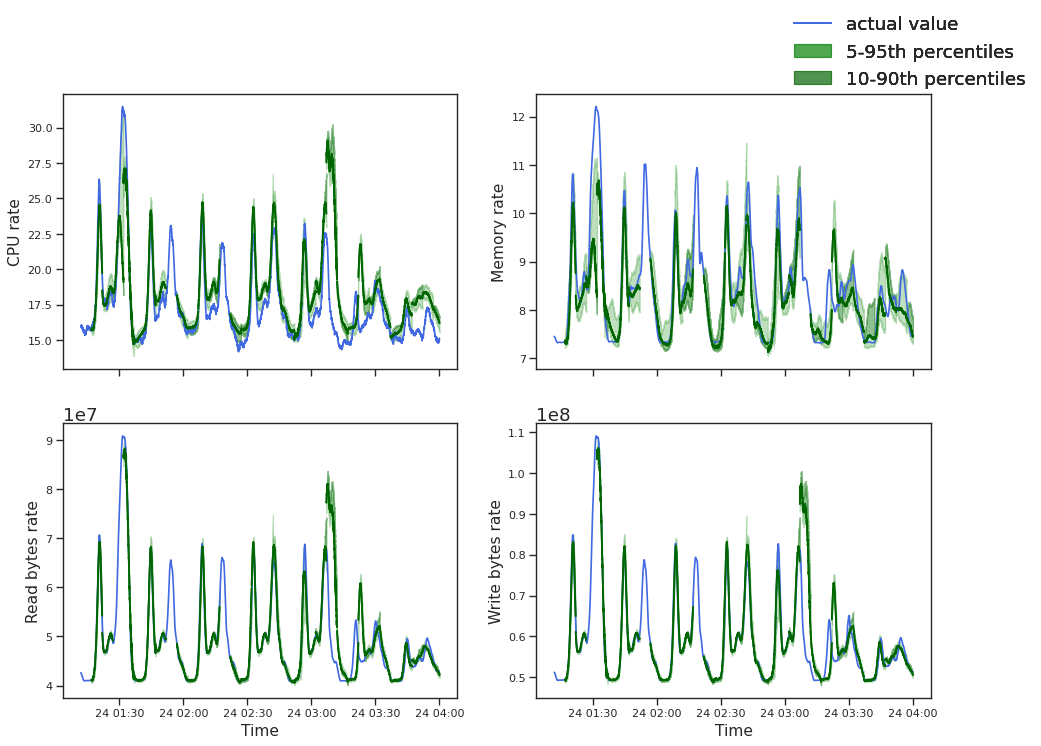

In [27]:
from matplotlib.pyplot import figure

lable_dic = {'cpu_rate': "CPU rate", 'memory_rate': 'Memory rate',
             'read_bytes_rate': "Read bytes rate", "write_bytes_rate": 'Write bytes rate'}

# subplot_custom(train, axs.flatten()[0],fig)

gcf_list = []
std_ths_plot = [0.05] 
for std_th in std_ths_plot:
    fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=80, sharex=True)
    print(std_th)
    plt_eval_test =  dl.scaler.inverse_transform(eval_test)
    ax_i = -1
    for col_name in test_cols:
        ax_i+=1
#         figure(figsize=(8, 4), dpi=120)
        
        plots = []
        
        subplot_custom(plt_eval_test[col_name], axs.flatten()[ax_i], fig,color="royalblue", label="actual value")
#         .plot()
        
        ic = 0
        for series in plot_dic[std_th][col_name]:
            if series.is_probabilistic:
                org_col_name = series.components[0]
                #Since sklearn inverse transform needs full dim data, we need replicate the col
                tmp_series = series.copy()
                tmp_series.with_columns_renamed(tmp_series.columns[0], "None")
                for i in range(4):
                    series = series.with_columns_renamed(series.columns[i],train.components[i])
                    if i == 3:
                        continue
                    series = series.concatenate(tmp_series,axis=1)
                    
                
                plt_series = dl.scaler.inverse_transform(series)
                plt_series = plt_series[org_col_name]
                
                if ic == 0:
                    subplot_custom (plt_series,axs.flatten()[ax_i], fig,low_quantile=0.05, high_quantile=0.95, color="green", label_to_use="5-95th percentiles")
                    subplot_custom (plt_series,axs.flatten()[ax_i], fig,low_quantile=0.1, high_quantile=0.9, color="darkgreen", label_to_use="10-90th percentiles")
#                     plot_custom (series, color="darkgreen", label_to_use="mean predicted")
                    ic =1
                    continue
                subplot_custom (plt_series,axs.flatten()[ax_i], fig,low_quantile=0.05, high_quantile=0.95, color="green")
                subplot_custom (plt_series,axs.flatten()[ax_i], fig,low_quantile=0.1, high_quantile=0.9, color="darkgreen")
#                 plot_custom (series, color="darkgreen")
                
                
#         axs.flatten()[ax_i].legend(prop={'size': 10})
        if ax_i >= 2:
            axs.flatten()[ax_i].set_xlabel("Time", fontsize=14, fontweight="normal")
        axs.flatten()[ax_i].set_ylabel(lable_dic[col_name], fontsize=14, fontweight="normal")
        handles, labels = axs.flatten()[ax_i].get_legend_handles_labels()
        axs.flatten()[ax_i].tick_params(axis='both', which='major', labelsize=10)
        axs.flatten()[ax_i].tick_params(axis='both', which='minor', labelsize=8)
        fig.legend(handles, labels, loc='upper right')
        fig.savefig(str(std_th)+".pdf")
#         axs.flatten()[ax_i].plot()
#     fig.legend(label)
#         axs.flatten()[ax_i].plot()
#         gcf_list.append(plt.gcf())
#         axs.flatten()[ax_i].savefig(col_name+"_"+str(std_th)+".pdf")
#         axs.flatten()[ax_i].show()

In [12]:
cols_dic = {}
for test_col in test_cols:
    cols_dic[test_col] = []
for _, dic in saved_pct.items():
    for key in test_cols:
        cols_dic[key].append(dic[key][0])

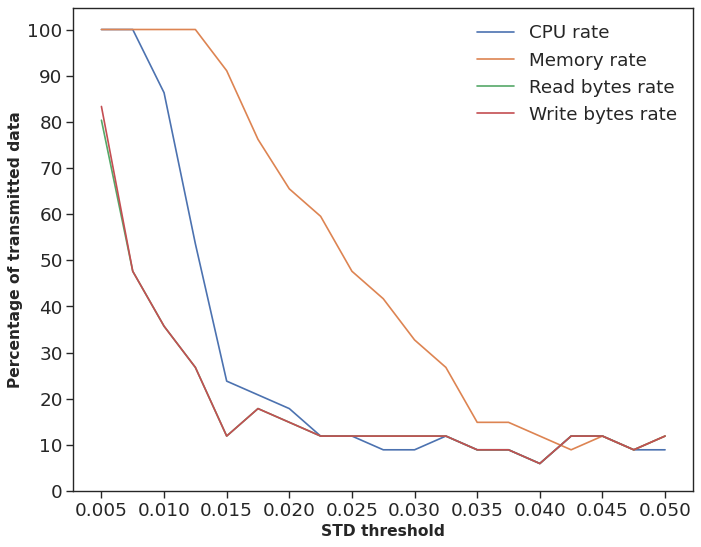

In [20]:
import seaborn as sns

# Prettier plotting with seaborn
sns.set(font_scale=1.5)
# Ticks instead of whitegrid in order to demonstrate changes to plot ticks better
sns.set_style("ticks")


fig, ax = plt.subplots(figsize=(10, 8), dpi=80)

for key, value in cols_dic.items():
    plt.plot(std_ths, value, label=key)
    
ax.set_xticks(np.arange(0.005, 0.055, 0.005))
ax.set_yticks(np.arange(0.0, 110, 10))
ax.set_xlabel("STD threshold", fontsize=14)
ax.set_ylabel("Percentage of transmitted data", fontsize=14)
ax.legend(labels=["CPU rate","Memory rate","Read bytes rate","Write bytes rate"])

# ax.set_xticks(np.arange(0.0, 0.06, 0.01))
# ax.set_ylim()
# ax.set_xlim(0.04,0.0)
# plt.legend()
plt.savefig("transmit_std.pdf")

In [32]:
# for col in test.columns.to_list():
#     test[col].to_csv(col+".csv",index=False,header=False)

In [22]:
matlab_cols = {
    'cpu_rate' : [ 6.78504116655094,7.08263069139966,7.82660450352148,8.37218529907747,
                  8.71937307806765,8.91776609463346,9.3145521277651,10.3065172105942,
                  10.9512945144331,12.141652613828,12.8856264259498,14.4727705584763,
                  15.9111199285785,17.8950500942367,20.226168038885,23.261581192342,28.0825314948914,
                  35.4528320603115,47.0489038785835],
    'memory_rate' : [6.78504116655094,7.42981847038985,7.87620275766292,8.32258704493601,8.6697748239262,9.36415038190655,9.76093641503819,10.6537049895844,11.4472770558476,12.1912508679694,13.1336176966571,14.2743775419105,15.9111199285785,17.6470588235294,19.8293820057534,22.408491221109,26.1878781866878,30.9889891875806,38.1509770856066
],
    'read_bytes_rate' : [8.07459577422874,8.37218529907747,9.06656085705784,9.41374863604801,9.959329431604,10.3561154647356,11.3480805475647,11.7944648348378,12.6376351552425,13.6791984922131,14.4727705584763,15.8615216744371,17.498264061105,18.9366134312072,21.3669278841385,23.6484475746454,27.4179148893959,32.0107132228946,38.8949508977284
],
    'write_bytes_rate' : [8.07459577422874,8.57057831564329,8.81856958635056,9.51294514433091,10.0585259398869,10.4553119730186,11.1992857851404,12.0920543596865,12.5880369011011,13.7287967463545,14.6711635750422,15.9111199285785,17.498264061105,19.0358099394901,21.3272492808253,23.7972423370697,27.3782362860827,31.990873921238,38.9544688026981
]
    
}

In [10]:
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

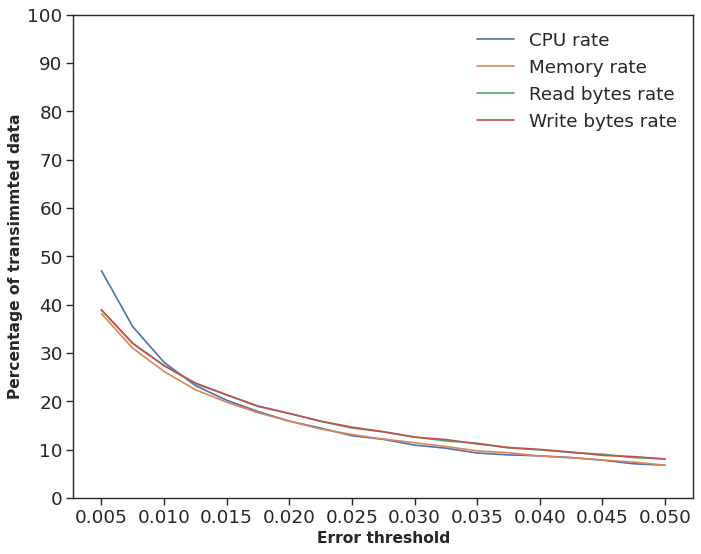

In [23]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=80)



for key, value in matlab_cols.items():
    plt.plot(std_ths, np.flip(value), label=key)
ax.set_xticks(np.arange(0.005, 0.055, 0.005))
ax.set_yticks(np.arange(0.0, 110, 10))
ax.set_xlabel("Error threshold", fontsize=14)
ax.set_ylabel("Percentage of transimmted data", fontsize=14)

# ax.set_xlim(0.04,0.0)
# plt.legend()
ax.legend(labels=["CPU rate","Memory rate","Read bytes rate","Write bytes rate"])

plt.savefig("transmit_err.pdf")